# Procesamiento de datos

In [9]:
import pandas as pd
import numpy as np
import glob

In [10]:
# Buscar todos los CSV en la carpeta
archivos = glob.glob("datasets/*.csv")

print("Archivos encontrados:")
for f in archivos:
    print(f)

# Cargar todos los CSV en una lista de DataFrames, ignorando líneas problemáticas
dataframes = []
for f in archivos:
    try:
        df = pd.read_csv(f, on_bad_lines='skip')
        dataframes.append(df)
    except Exception as e:
        print(f"Error al leer {f}: {e}")


Archivos encontrados:
datasets\API_EN.GHG.FGAS.IP.MT.CE.AR5_DS2_es_csv_v2_75297.csv
datasets\API_ER.H2O.FWTL.ZS_DS2_es_csv_v2_49721.csv
datasets\API_FB.BNK.CAPA.ZS_DS2_es_csv_v2_35034.csv
datasets\API_SH.STA.SMSS.ZS_DS2_es_csv_v2_55700.csv
datasets\OWID_CB.csv
datasets\points_data.csv
datasets\WDPA_WDOECM_Aug2025_Public_HND_csv.csv


In [11]:
def limpieza_basica(df):
    # 1. Eliminar duplicados
    df = df.drop_duplicates()

    # 2. Manejo de valores nulos
    for col in df.columns:
        if df[col].dtype == "object":  # Texto
            df[col] = df[col].fillna("desconocido").str.strip().str.lower()
        else:  # Numéricos
            df[col] = df[col].fillna(df[col].median())

    # 3. Intentar conversión de fechas
    for col in df.columns:
        if "fecha" in col.lower():
            df[col] = pd.to_datetime(df[col], errors="coerce")
    
    return df


In [12]:
dataframes_limpios = []

for archivo, df in zip(archivos, dataframes):
    df_limpio = limpieza_basica(df)
    dataframes_limpios.append(df_limpio)
    print(f"{archivo} -> Filas originales: {df.shape[0]}, Filas limpias: {df_limpio.shape[0]}")


datasets\API_EN.GHG.FGAS.IP.MT.CE.AR5_DS2_es_csv_v2_75297.csv -> Filas originales: 266, Filas limpias: 266
datasets\API_ER.H2O.FWTL.ZS_DS2_es_csv_v2_49721.csv -> Filas originales: 266, Filas limpias: 266
datasets\API_FB.BNK.CAPA.ZS_DS2_es_csv_v2_35034.csv -> Filas originales: 266, Filas limpias: 266
datasets\API_SH.STA.SMSS.ZS_DS2_es_csv_v2_55700.csv -> Filas originales: 266, Filas limpias: 266
datasets\OWID_CB.csv -> Filas originales: 3079976, Filas limpias: 3079976
datasets\points_data.csv -> Filas originales: 1375, Filas limpias: 1375
datasets\WDPA_WDOECM_Aug2025_Public_HND_csv.csv -> Filas originales: 119, Filas limpias: 119


In [13]:
import os

# Crear carpeta si no existe
os.makedirs("data_limpios", exist_ok=True)

# Guardar cada DataFrame limpio con el mismo nombre de archivo
for archivo, df in zip(archivos, dataframes_limpios):
    nombre = os.path.basename(archivo)  # nombre del archivo original
    df.to_csv(os.path.join("data_limpios", f"limpio_{nombre}"), index=False)

print("✅ Archivos limpios guardados en carpeta 'data_limpios'")


✅ Archivos limpios guardados en carpeta 'data_limpios'


# Aplicacion de Tecnicas de analisis de datos

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [15]:
archivos = [
    "data_limpios/limpio_agua_dulce.csv",
    "data_limpios/limpio_capital_bancario.csv",
    "data_limpios/limpio_f-gases.csv",
    "data_limpios/limpio_sanitation_services.csv"
]

dataframes = [pd.read_csv(f) for f in archivos]

# Revisar la estructura de uno
dataframes[0].head()


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,aruba,abw,"extracción anual de agua dulce, total (% de re...",er.h2o.fwtl.zs,NaN,NaN,37.5,39.375,41.25,21.914995,...,8.645437,8.644658,8.644658,8.629986,8.644658,8.644658,NaN,NaN,NaN,NaN
1,desconocido,afe,"extracción anual de agua dulce, total (% de re...",er.h2o.fwtl.zs,NaN,NaN,37.5,39.375,41.25,21.914995,...,4.868129,4.881813,4.917538,4.960944,5.012011,5.041739,NaN,NaN,NaN,NaN
2,afganistán,afg,"extracción anual de agua dulce, total (% de re...",er.h2o.fwtl.zs,NaN,NaN,37.5,39.375,41.25,21.914995,...,43.015907,43.015907,43.015907,43.015907,43.015907,43.015907,NaN,NaN,NaN,NaN
3,desconocido,afw,"extracción anual de agua dulce, total (% de re...",er.h2o.fwtl.zs,NaN,NaN,37.5,39.375,41.25,21.914995,...,1.624230,1.617936,1.693410,1.704014,1.707172,1.705313,NaN,NaN,NaN,NaN
4,angola,ago,"extracción anual de agua dulce, total (% de re...",er.h2o.fwtl.zs,NaN,NaN,37.5,39.375,41.25,21.914995,...,0.476824,0.476824,0.476824,0.476824,0.476824,0.476824,NaN,NaN,NaN,NaN


In [22]:
def transformar(df):
    df_long = df.melt(
        id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        var_name="Year",
        value_name="Value"
    )
    df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
    return df_long

dataframes_long = [transformar(df) for df in dataframes]



c:\Users\gerar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


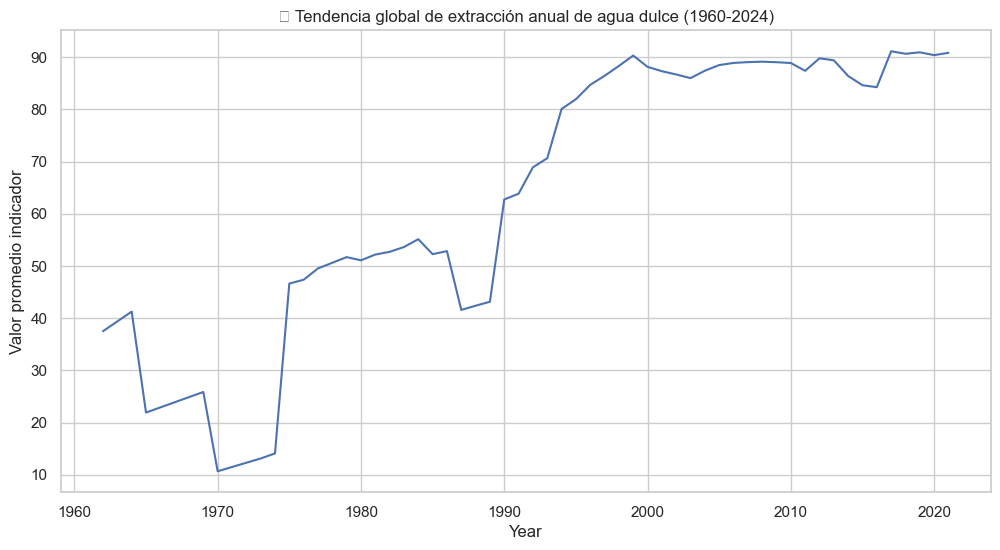

In [32]:
df_def = dataframes_long[0] 

# Agrupar por año (promedio global)
trend = df_def.groupby("Year")["Value"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="Year", y="Value")
plt.title("🌍 Tendencia global de extracción anual de agua dulce (1960-2024)")
plt.ylabel("Valor promedio indicador")
plt.show()



c:\Users\gerar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


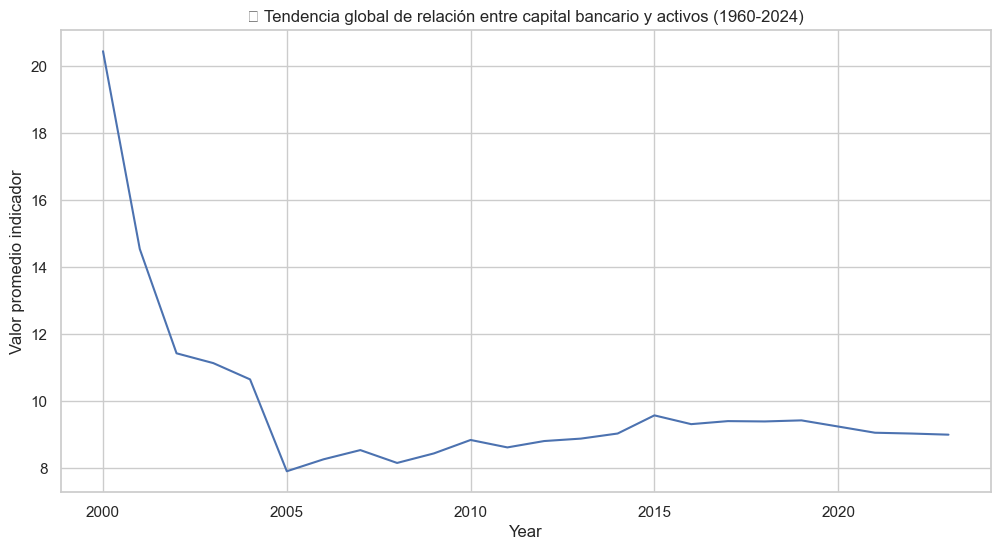

In [20]:
df_def = dataframes_long[1] 

# Agrupar por año (promedio global)
trend = df_def.groupby("Year")["Value"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="Year", y="Value")
plt.title("🌍 Tendencia global de relación entre capital bancario y activos (1960-2024)")
plt.ylabel("Valor promedio indicador")
plt.show()

c:\Users\gerar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


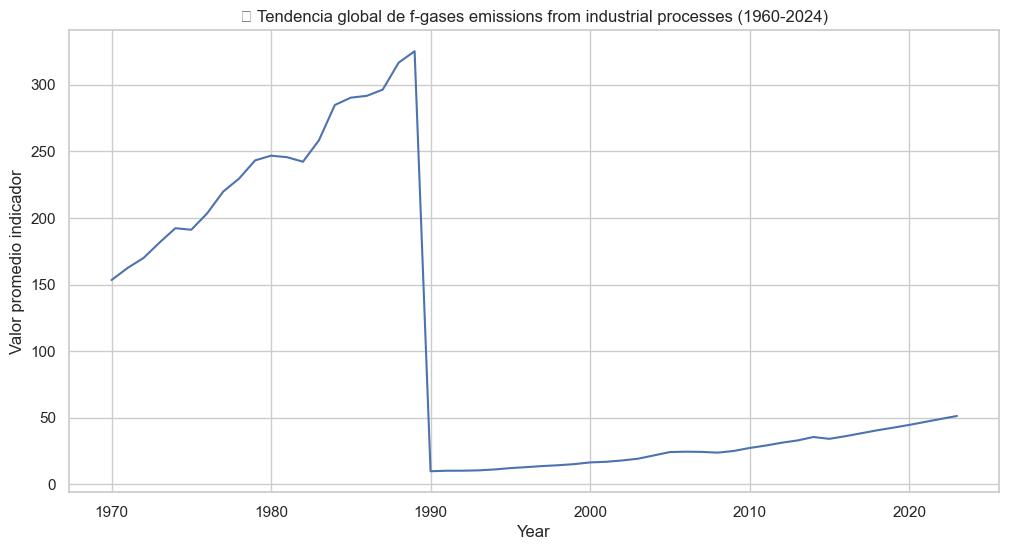

In [23]:
df_def = dataframes_long[2] 

# Agrupar por año (promedio global)
trend = df_def.groupby("Year")["Value"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="Year", y="Value")
plt.title("🌍 Tendencia global de f-gases emissions from industrial processes (1960-2024)")
plt.ylabel("Valor promedio indicador")
plt.show()

c:\Users\gerar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


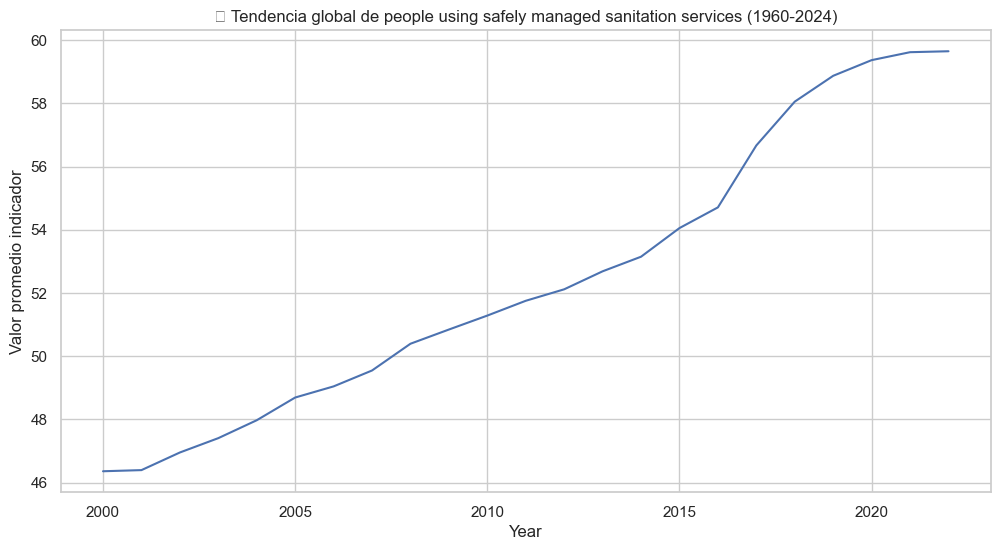

In [24]:
df_def = dataframes_long[3] 

# Agrupar por año (promedio global)
trend = df_def.groupby("Year")["Value"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="Year", y="Value")
plt.title("🌍 Tendencia global de people using safely managed sanitation services (1960-2024)")
plt.ylabel("Valor promedio indicador")
plt.show()

# Modelo Predictivos

c:\Users\gerar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


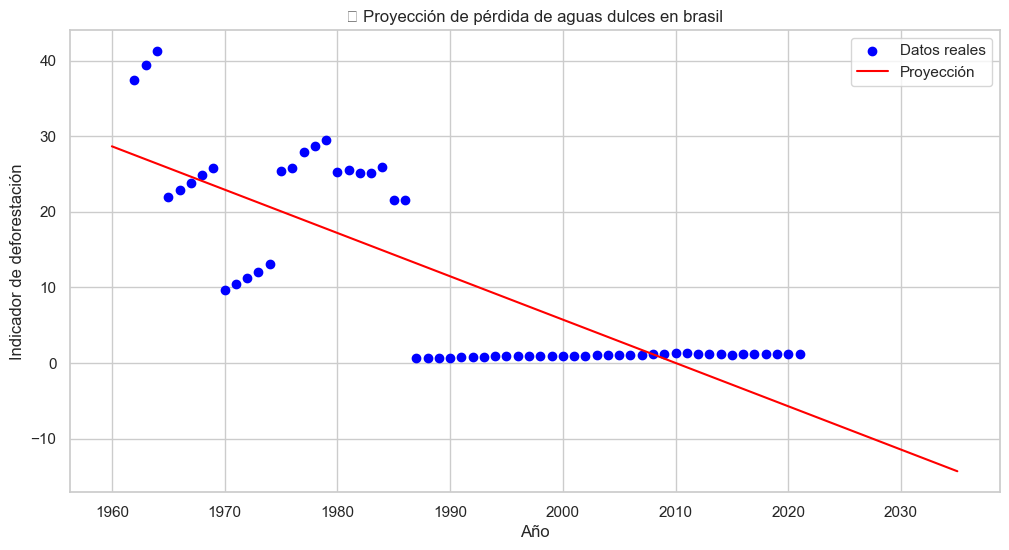

In [31]:
from sklearn.linear_model import LinearRegression
import numpy as np

df_def = dataframes_long[0]  

# Ejemplo: país específico
pais = "brasil"
df_pais = df_def[df_def["Country Name"] == pais].dropna(subset=["Value"])

if df_pais.empty:
	print(f"No hay datos disponibles para el país: {pais}")
else:
	X = df_pais["Year"].values.reshape(-1,1)
	y = df_pais["Value"].values

	# Entrenar modelo
	model = LinearRegression()
	model.fit(X, y)

	# Proyectar hasta 2035
	future_years = np.arange(1960, 2036).reshape(-1,1)
	y_pred = model.predict(future_years)

	# Visualización
	plt.figure(figsize=(12,6))
	plt.scatter(X, y, label="Datos reales", color="blue")
	plt.plot(future_years, y_pred, color="red", label="Proyección")
	plt.title(f"📉 Proyección de pérdida de aguas dulces en {pais}")
	plt.xlabel("Año")
	plt.ylabel("Indicador de deforestación")
	plt.legend()
	plt.show()
